In [39]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

sns.set_theme(style="darkgrid")
sns.set_palette("Set2")


In [40]:
data = pd.read_csv('output Plant Data.csv')

In [41]:
data

AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]

In [42]:
rename = {'AT': 'temp',
        'V': 'exhaust',
        'AP': 'pressure',
        'RH': 'humidity',
        'PE': 'output'}

data.rename(columns=rename, inplace=True)

numerical_features = ["temp", "exhaust", "pressure", "humidity"]

In [43]:
data = data.iloc[:1000]
data

temp  exhaust  pressure  humidity  output
0    14.96    41.76   1024.07     73.17  463.26
1    25.18    62.96   1020.04     59.08  444.37
2     5.11    39.40   1012.16     92.14  488.56
3    20.86    57.32   1010.24     76.64  446.48
4    10.82    37.50   1009.23     96.62  473.90
..     ...      ...       ...       ...     ...
995  23.84    49.21   1013.85     50.36  447.09
996  21.17    58.16   1017.16     68.11  452.02
997  19.94    58.96   1014.16     66.27  455.55
998   8.73    41.92   1029.41     89.72  480.99
999  16.39    41.67   1012.96     61.07  467.68

[1000 rows x 5 columns]

### 1. Exploratory Data Analysis

In [44]:
data.describe()

temp     exhaust     pressure     humidity       output
count  1000.000000  1000.00000  1000.000000  1000.000000  1000.000000
mean     19.331010    53.57365  1013.620570    73.119060   455.263590
std       7.359492    12.36834     6.137644    14.679826    16.942486
min       3.380000    25.36000   994.170000    25.890000   425.290000
25%      13.415000    41.61000  1009.597500    63.547500   440.965000
50%      19.985000    50.32000  1013.290000    74.620000   452.580000
75%      25.427500    65.06000  1017.582500    84.712500   469.190000
max      35.560000    79.74000  1033.300000   100.150000   495.760000

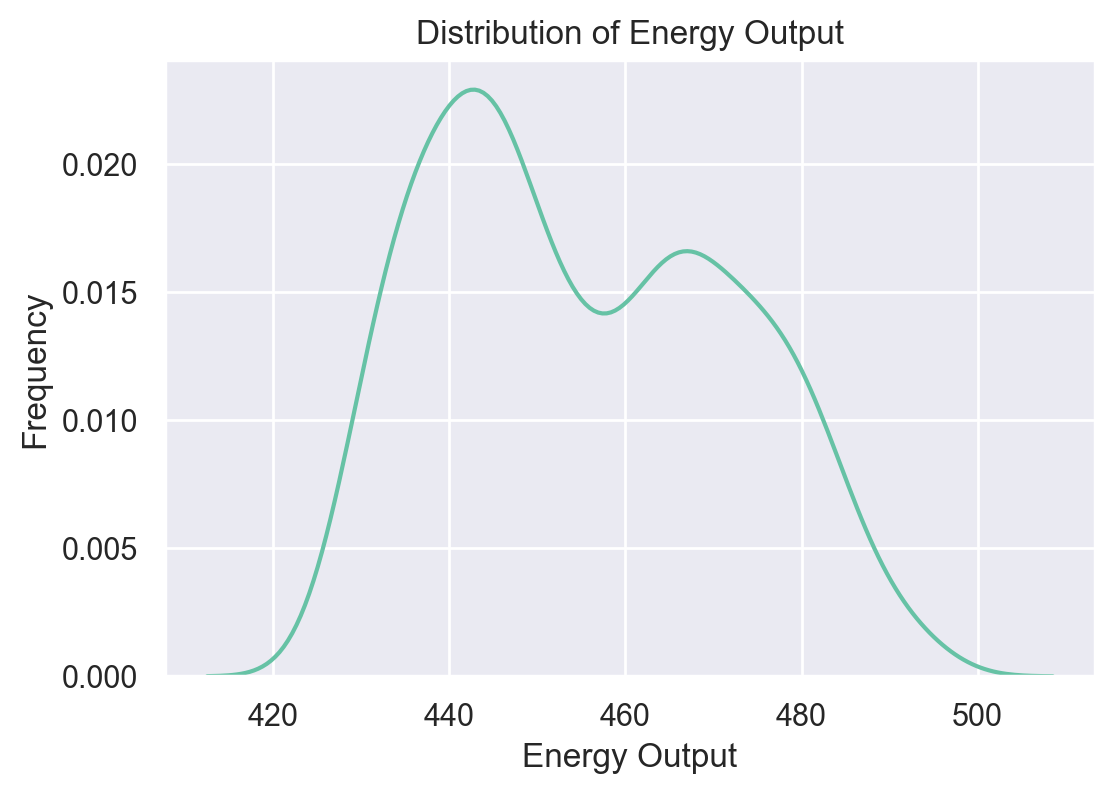

In [87]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.kdeplot(data['output'])
plt.title('Distribution of Energy Output')
plt.xlabel('Energy Output')
plt.ylabel('Frequency')
plt.show()

- The distribution looks like a bimodal than a normal distribution, it has 2 central tendencies

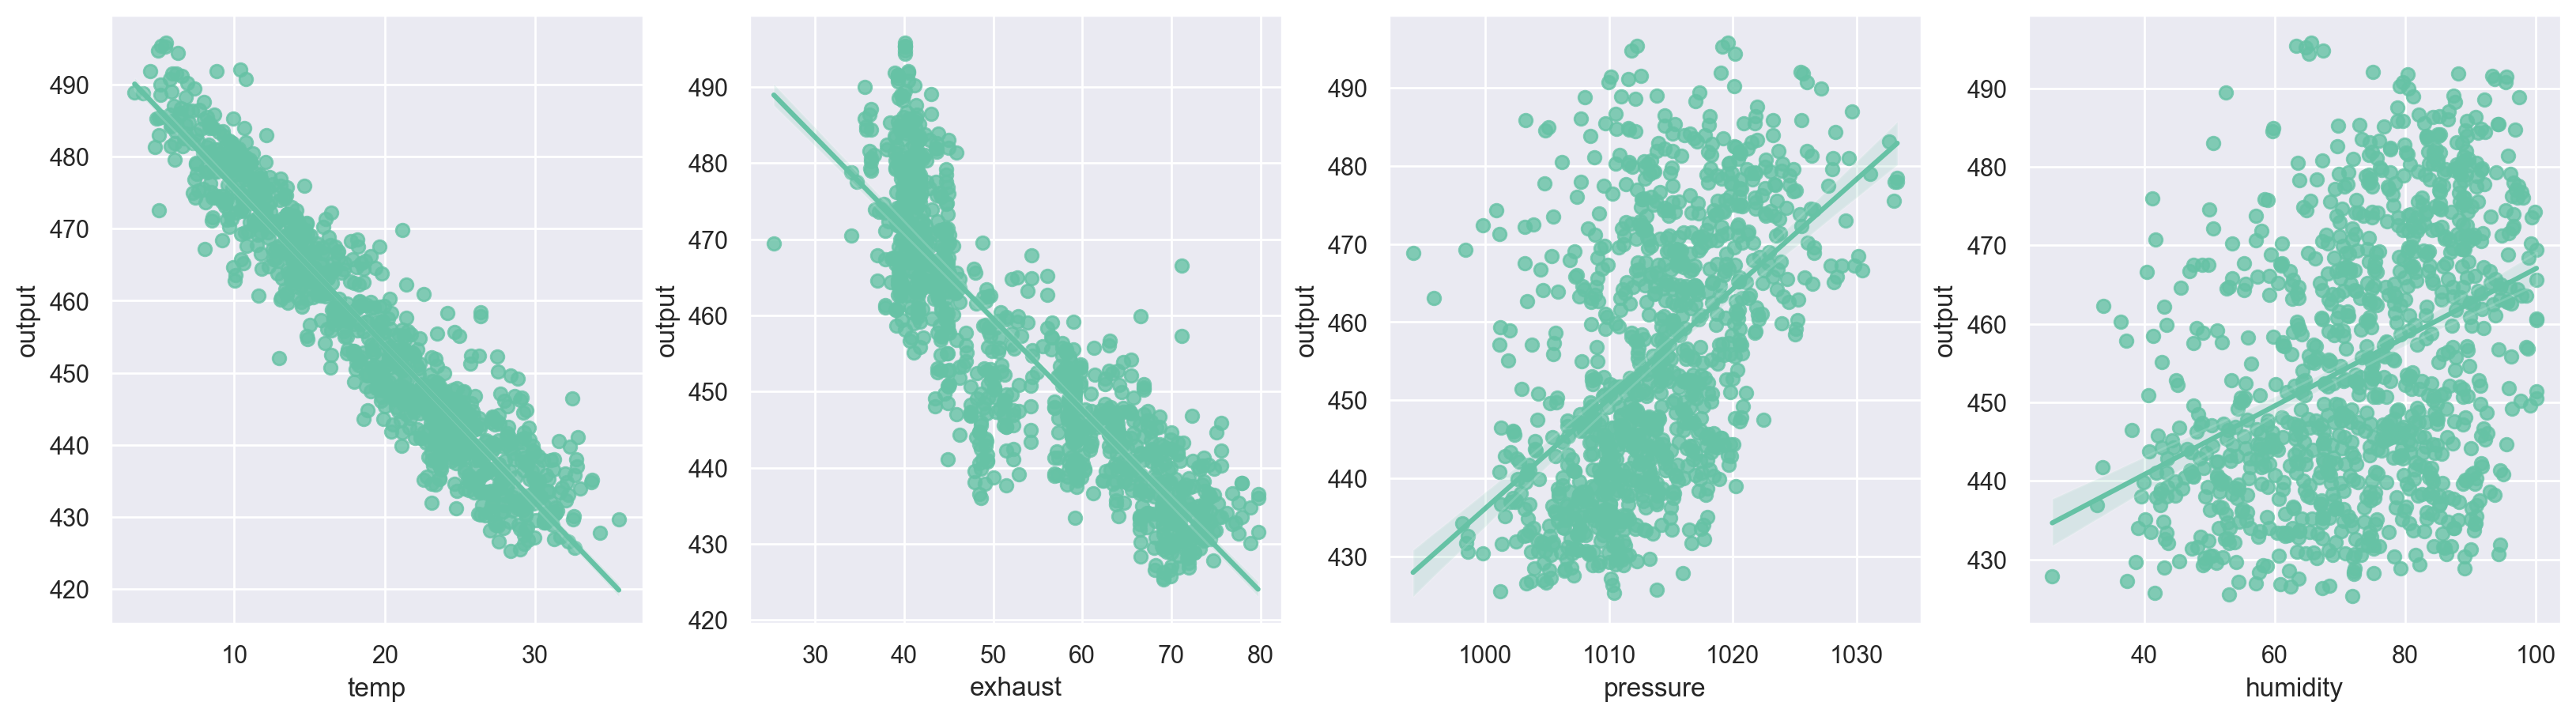

In [46]:
# Visualize the distribution of the target variable
fig,ax = plt.subplots(nrows=1,ncols=len(numerical_features),figsize=(20,5))
for idx in range(len(numerical_features)) : 
    
    sns.regplot(data,x=numerical_features[idx],y="output",ax=ax[idx])

We can see that temp and exhaust has linear trend

### 2. Choosing Initial Model

For starters we use a simple linear model first, using temp to predict energy output

$output =  \alpha + \beta * temp$

### 3. Scaling and Transforming Parameter

In [47]:
data['log_output'] = np.log(data['output'])
data['log_temp'] = np.log(data['temp'])
data['log_exhaust'] = np.log(data['exhaust'])
data['log_pressure'] = np.log(data['pressure'])
data['log_humid'] = np.log(data['humidity'])

C:\Users\Mint_01\AppData\Local\Temp\ipykernel_15980\226648720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_output'] = np.log(data['output'])
C:\Users\Mint_01\AppData\Local\Temp\ipykernel_15980\226648720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_temp'] = np.log(data['temp'])
C:\Users\Mint_01\AppData\Local\Temp\ipykernel_15980\226648720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [48]:
data.head()

temp  exhaust  pressure  humidity  output  log_output  log_temp  \
0  14.96    41.76   1024.07     73.17  463.26    6.138288  2.705380   
1  25.18    62.96   1020.04     59.08  444.37    6.096658  3.226050   
2   5.11    39.40   1012.16     92.14  488.56    6.191462  1.631199   
3  20.86    57.32   1010.24     76.64  446.48    6.101395  3.037833   
4  10.82    37.50   1009.23     96.62  473.90    6.160996  2.381396   

   log_exhaust  log_pressure  log_humid  
0     3.731939      6.931540   4.292786  
1     4.142500      6.927597   4.078892  
2     3.673766      6.919842   4.523309  
3     4.048650      6.917943   4.339119  
4     3.624341      6.916943   4.570786

Text(0.5, 1.0, 'Original Scale')

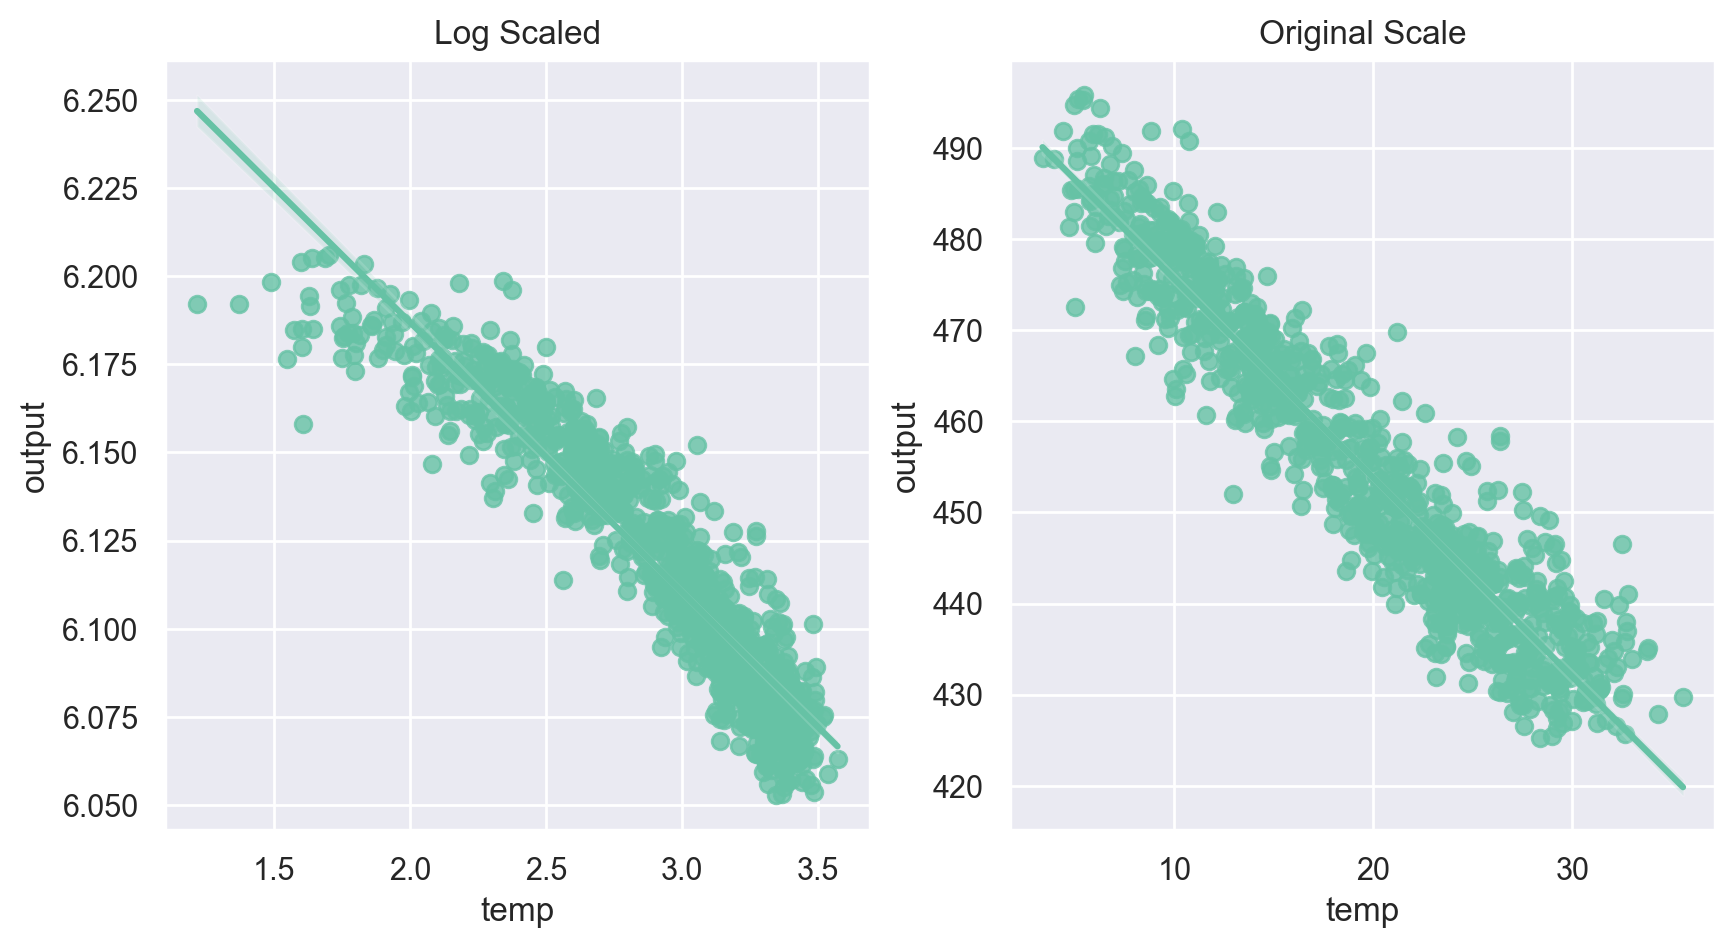

In [49]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.regplot(x=np.log(data['temp']),y=np.log(data['output']),ax=ax[0])
sns.regplot(x=data['temp'],y=data['output'],ax=ax[1])


ax[0].set_title('Log Scaled')
ax[1].set_title('Original Scale')

### 4. Prior Selection and Predictive Checking


So how to choose our prior ? 

- For now we assume that the increase of temp can increase 5 to 8 million Watt
- The intercept we can assume has mean of 5 
$$
\begin{align}
\text{Energy Output}_i & \sim Normal(\mu_i,\sigma) \text{ [likelihood]} \\
\mu_i &= \alpha + \beta \cdot \text{temp}_i \\ 
\alpha & \sim Normal(\mu = 0.05,\sigma =0.25) \text{ [prior]} \\
\beta & \sim Normal(\mu = 0.05,\sigma =0.25) \text{ [prior]} \\
\sigma & \sim Expon(\lambda = 0.05)\text{ [prior]} \\
\end{align}
$$



<Axes: xlabel='log_output', ylabel='Density'>

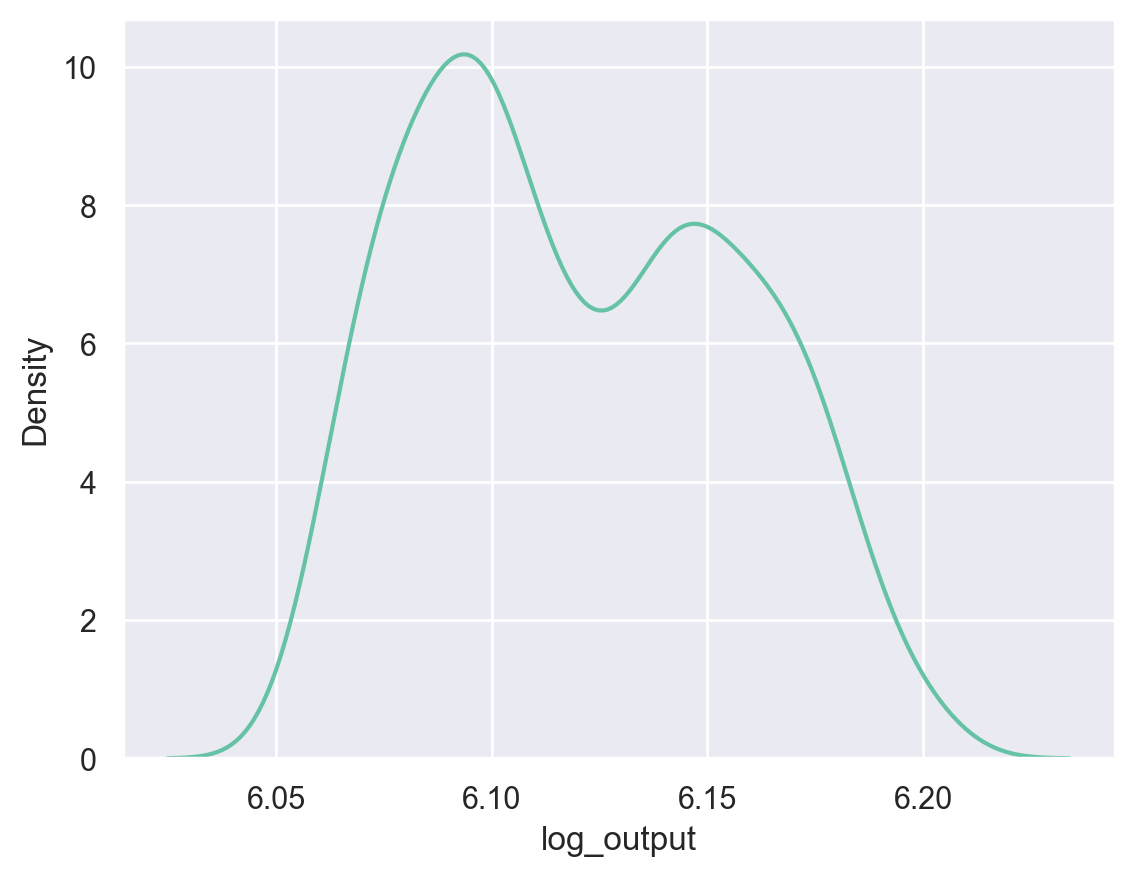

In [50]:
sns.kdeplot(data=data,x='log_output')

In [51]:
with pm.Model() as output_model1 :
#
  a = pm.Normal('a',0.05,0.25)
  b = pm.Normal('b',0.05,1)
  sigma = pm.Exponential('sigma',0.05)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b * data['log_temp'].values)
  likelihood = pm.Normal('energy_output',mu=linear_model,sigma=sigma,observed=data['log_output'].values)





In [52]:
with output_model1 :
      output_model1_prior = pm.sample_prior_predictive(draws=100)


Sampling: [a, b, energy_output, sigma]


Text(0.5, 1.0, 'Prior Prediction Plot using Original scale')

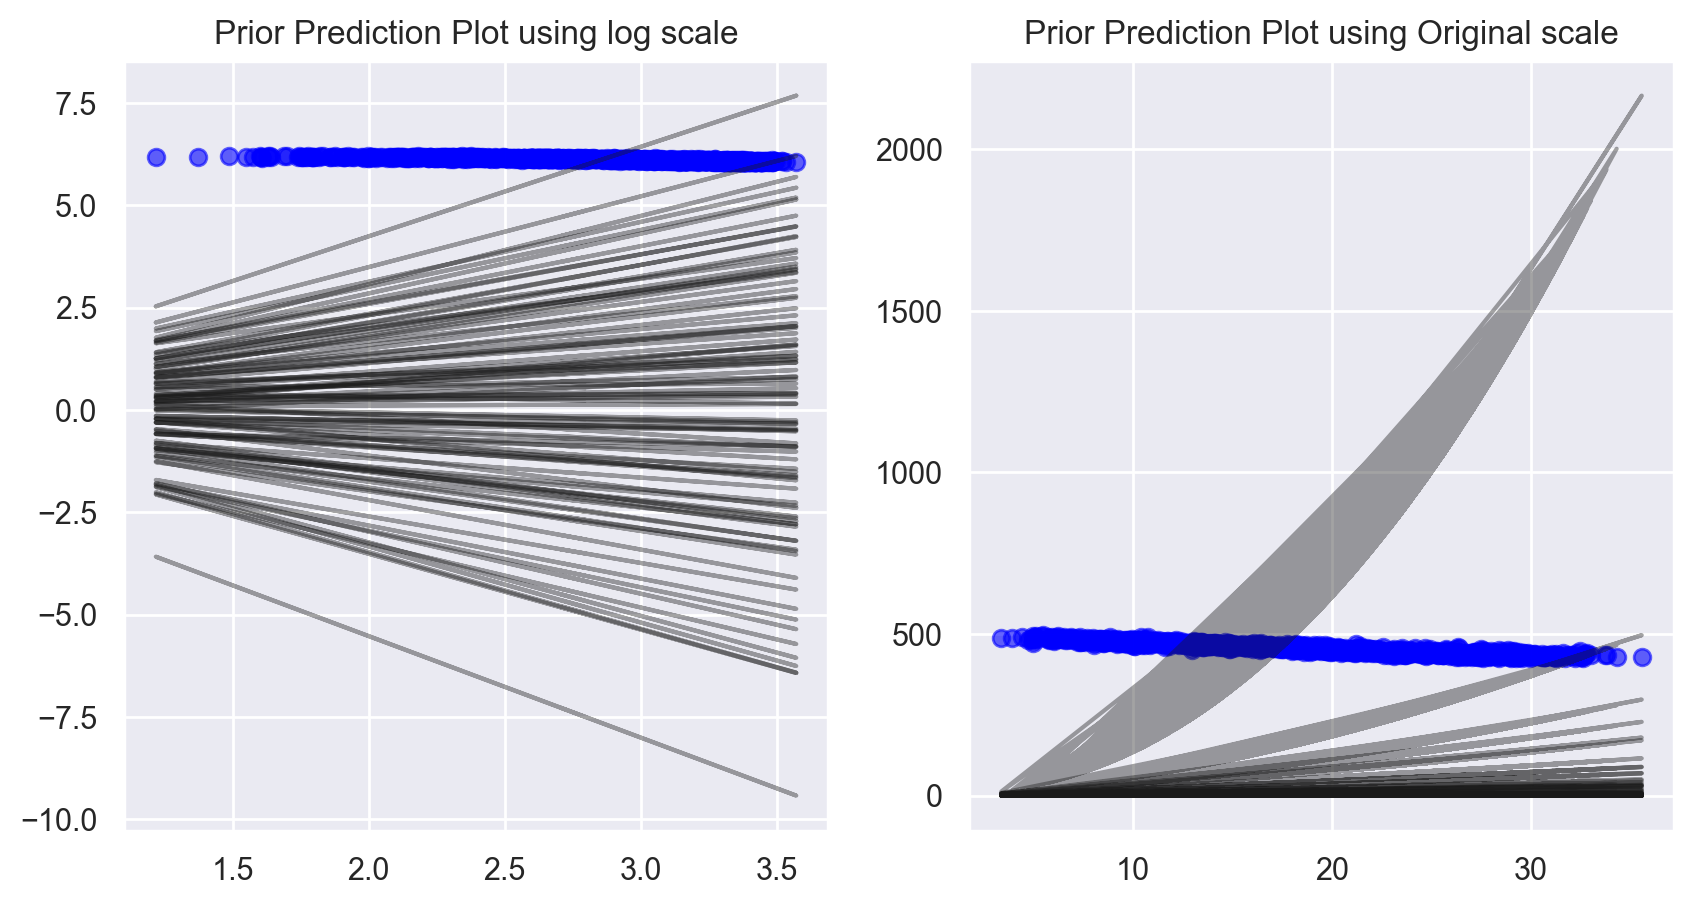

In [53]:
shape_prior_samples = output_model1_prior.prior['a'].values.flatten().shape[0]
n_data = data.shape[0] 
output_pred = np.zeros(( n_data , shape_prior_samples ))



for i, val in enumerate(data['log_temp']):
    # dont forget to inverse 
    output_pred[i] = output_model1_prior.prior["a"] + output_model1_prior.prior["b"]  * val

inverse_scaled_output = np.exp(output_pred)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i in range(shape_prior_samples) : 
    ax[0].plot(data['log_temp'],output_pred[:,i], c="k", alpha=0.4)

ax[0].scatter(data['log_temp'],data['log_output'], c="blue", alpha=0.6)
ax[0].set_title('Prior Prediction Plot using log scale')



for i in range(shape_prior_samples) : 
    ax[1].plot(data['temp'],inverse_scaled_output[:,i], c="k", alpha=0.4)

ax[1].scatter(data['temp'],data['output'], c="blue", alpha=0.6)
ax[1].set_title('Prior Prediction Plot using Original scale')


### 5. Fitting Model

In [54]:
with output_model1 :
      output_model1_trace = pm.sample(2000,random_seed=RANDOM_SEED, target_accept=0.9)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


In [55]:
az.summary(output_model1_trace,var_names=['a','b','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      6.339  0.003   6.334    6.344        0.0      0.0    2863.0    3178.0   
b     -0.076  0.001  -0.078   -0.075        0.0      0.0    2831.0    3094.0   
sigma  0.013  0.000   0.013    0.014        0.0      0.0    3626.0    3342.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

### 6. Checking Sampling Process

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

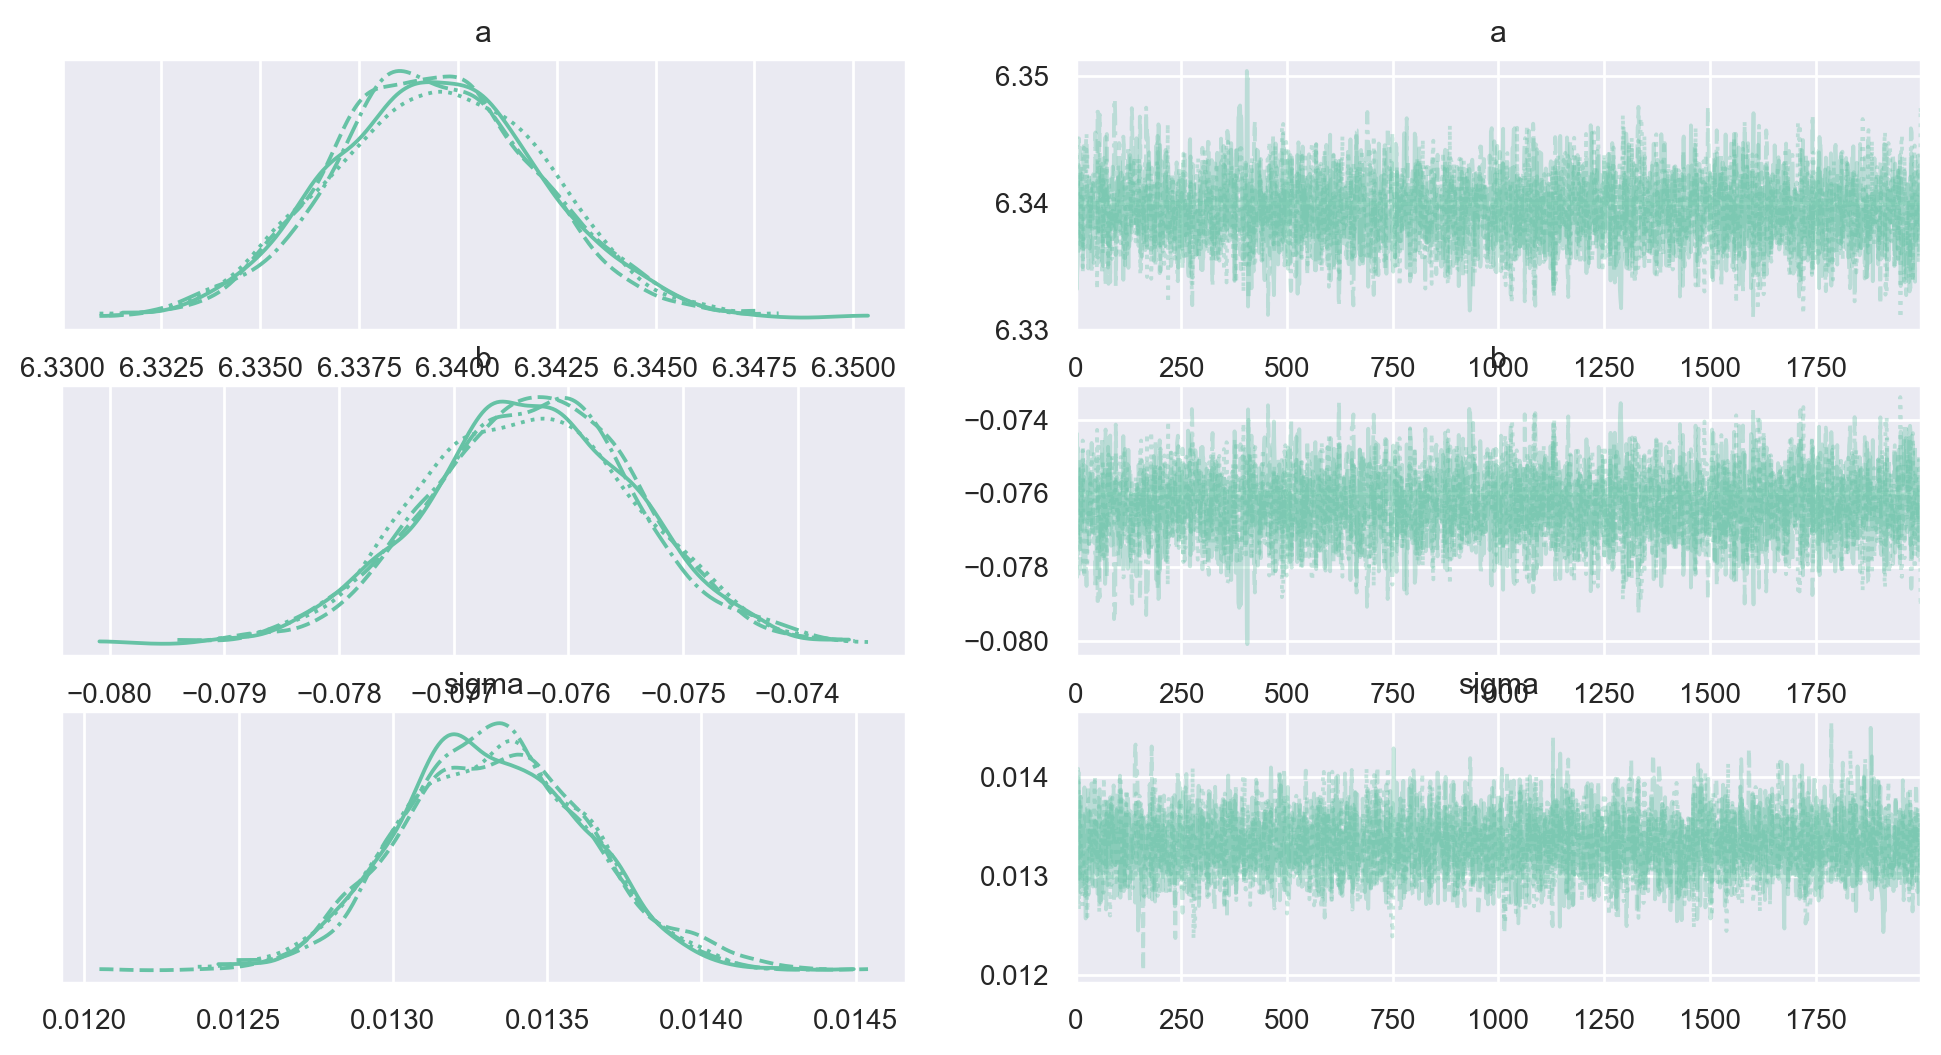

In [57]:
az.plot_trace(output_model1_trace,var_names=["~mu"])

array([[<Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n1'}>,
        <Axes: title={'center': 'a\n2'}>],
       [<Axes: title={'center': 'a\n3'}>,
        <Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>],
       [<Axes: title={'center': 'b\n2'}>,
        <Axes: title={'center': 'b\n3'}>,
        <Axes: title={'center': 'sigma\n0'}>],
       [<Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>]], dtype=object)

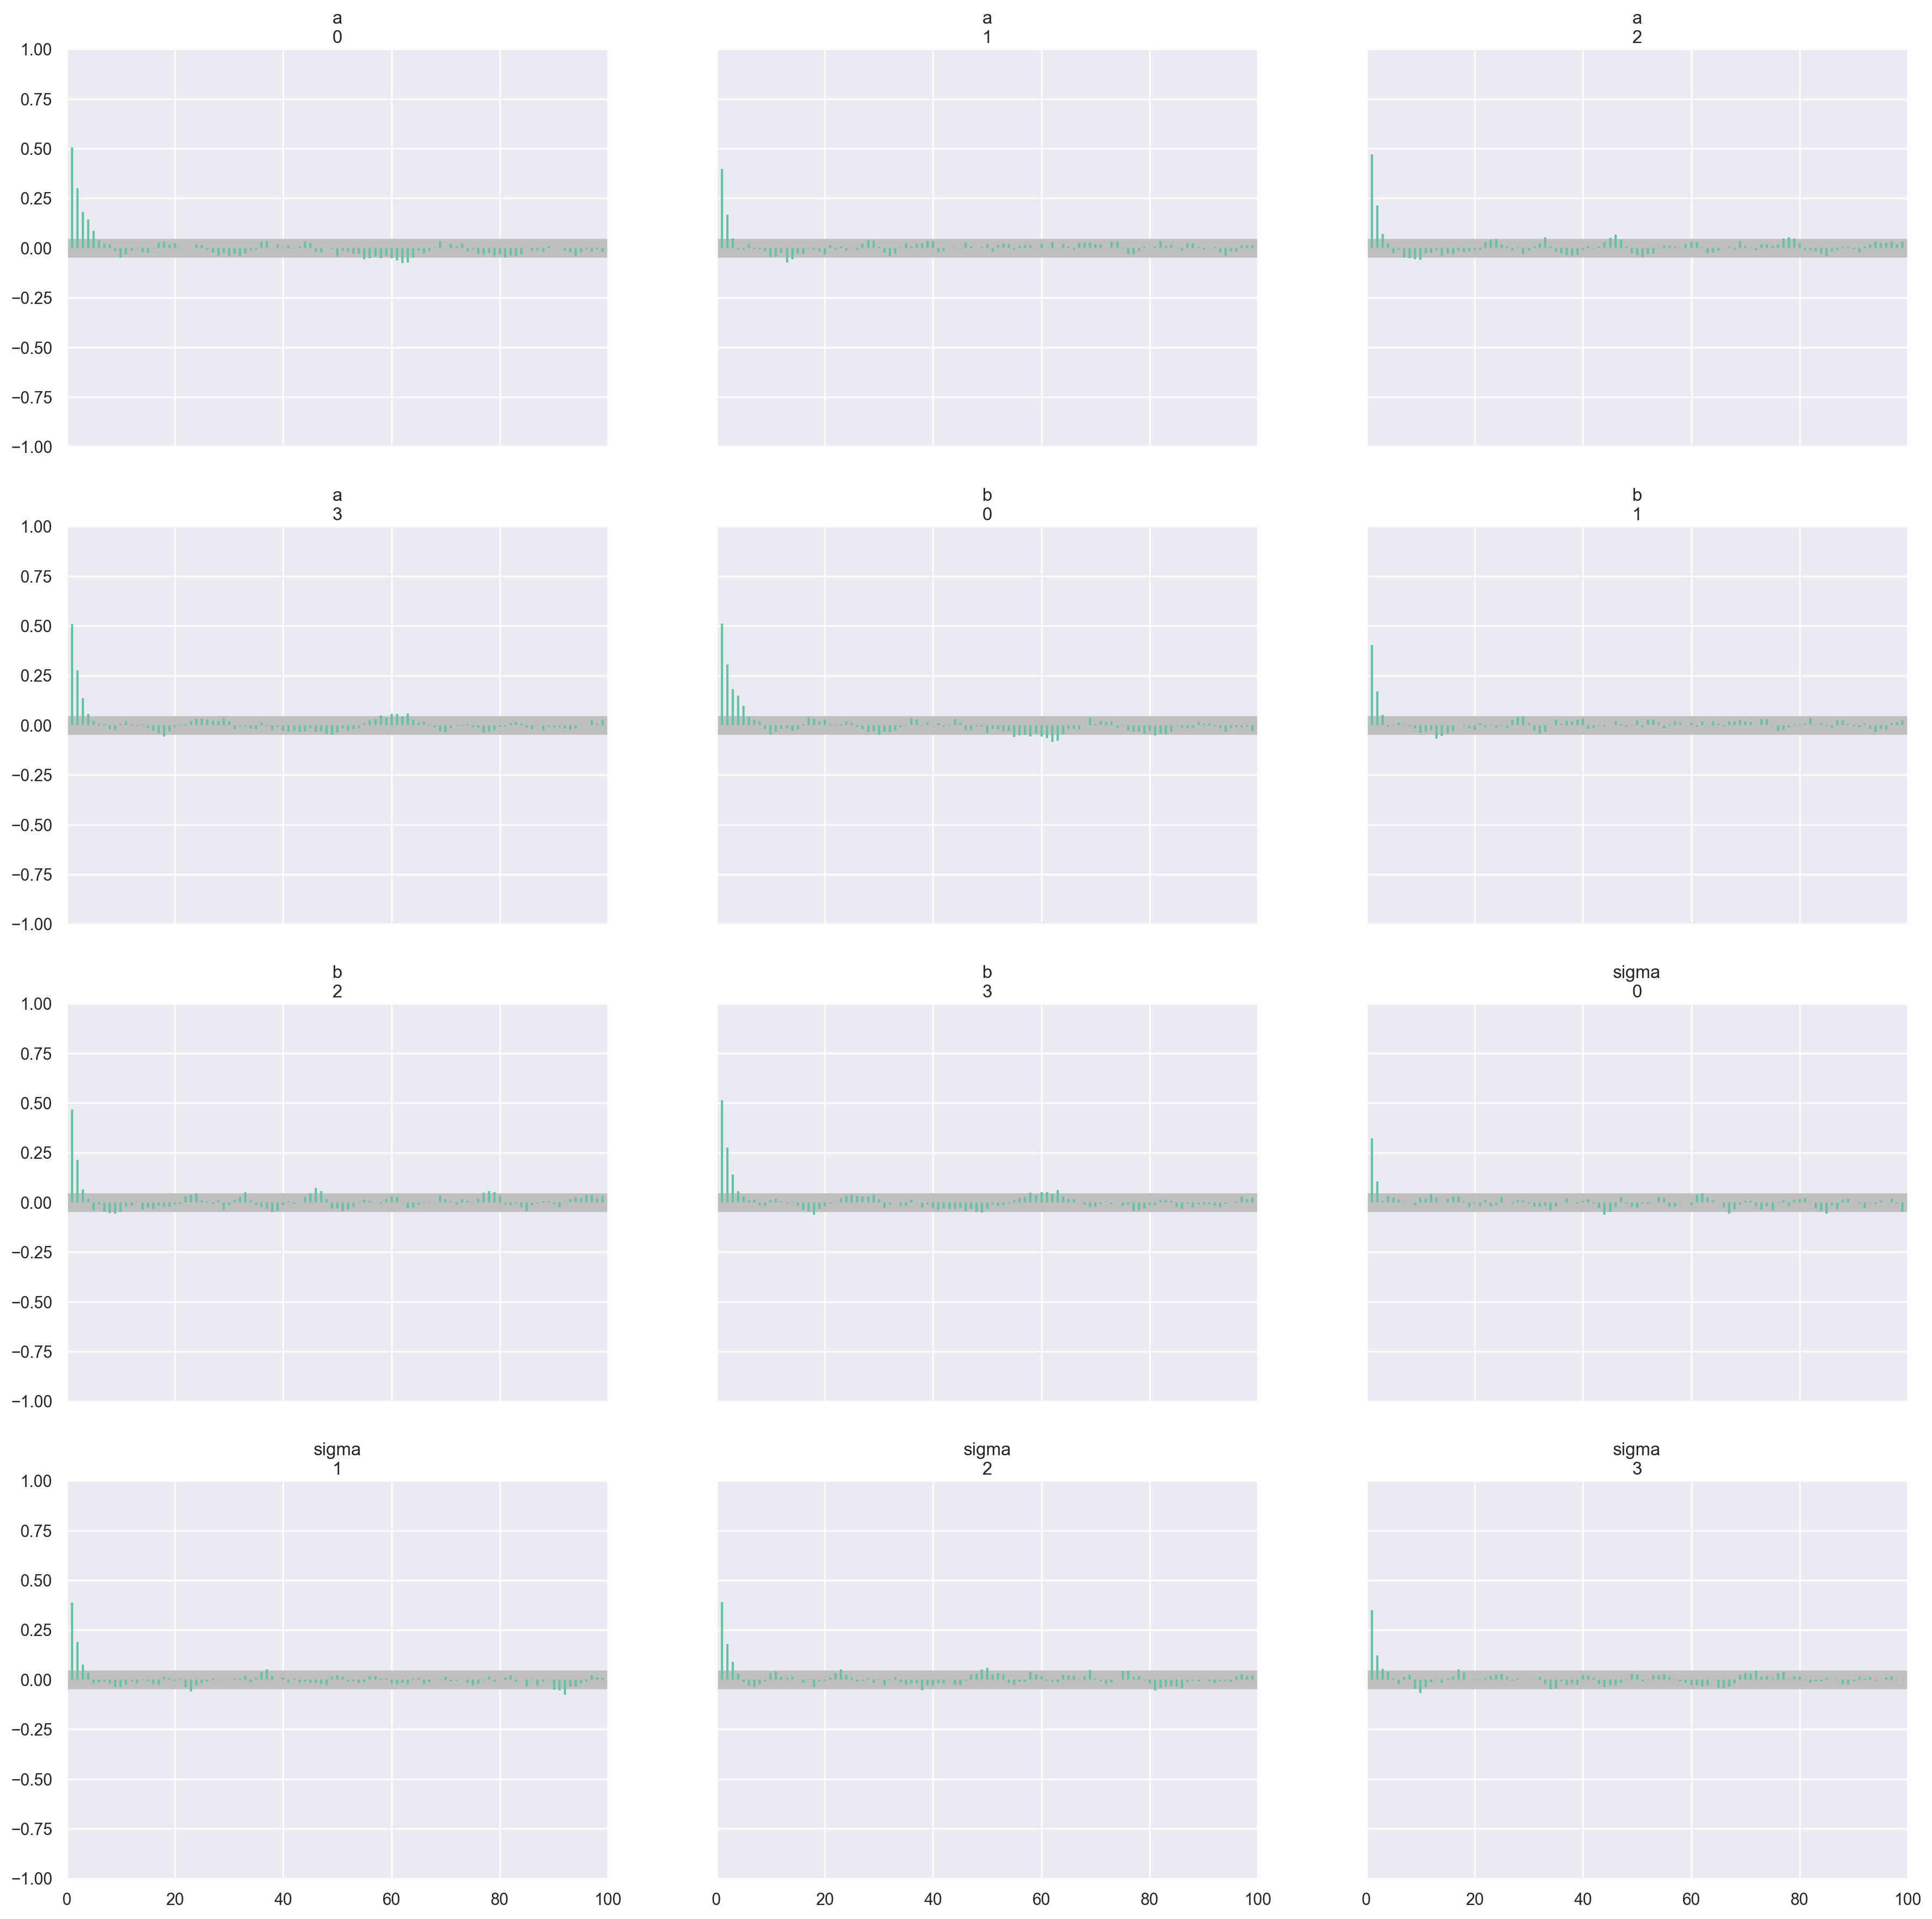

In [58]:
az.plot_autocorr(output_model1_trace,var_names=['a','b','sigma'])

### 6. Model Evaluation


#### Posterior Predictive Check

In [59]:
with output_model1 :
    output_model1_ppc = pm.sample_posterior_predictive(output_model1_trace,var_names=['energy_output'],
                                                       random_seed=72)


Sampling: [energy_output]


Output()

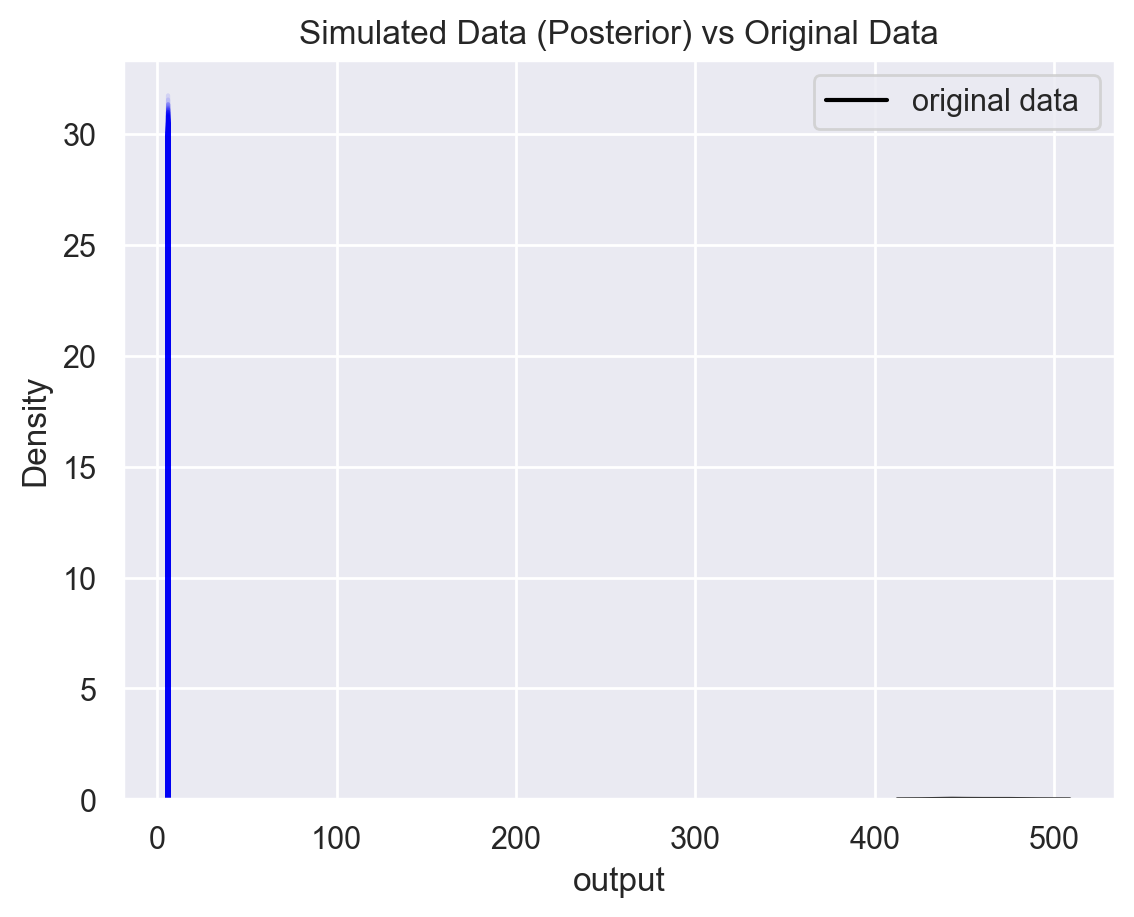

In [60]:
output_posterior = output_model1_ppc['posterior_predictive']['energy_output'].values
chain,draw,n_posterior_draw = output_posterior.shape
output_posterior = output_posterior.reshape(chain*draw,n_posterior_draw)

# plot the posterior 
fig,ax = plt.subplots()
for idx in range(output_posterior.shape[1]) : 
    sns.kdeplot(output_posterior[:,idx],alpha=0.1,color='blue')
sns.kdeplot(data['output'],label='original data ',color='black')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

In [61]:
output_model1_ppc['posterior_predictive']['energy_output'].values.shape

(4, 2000, 1000)

<Axes: xlabel='energy_output'>

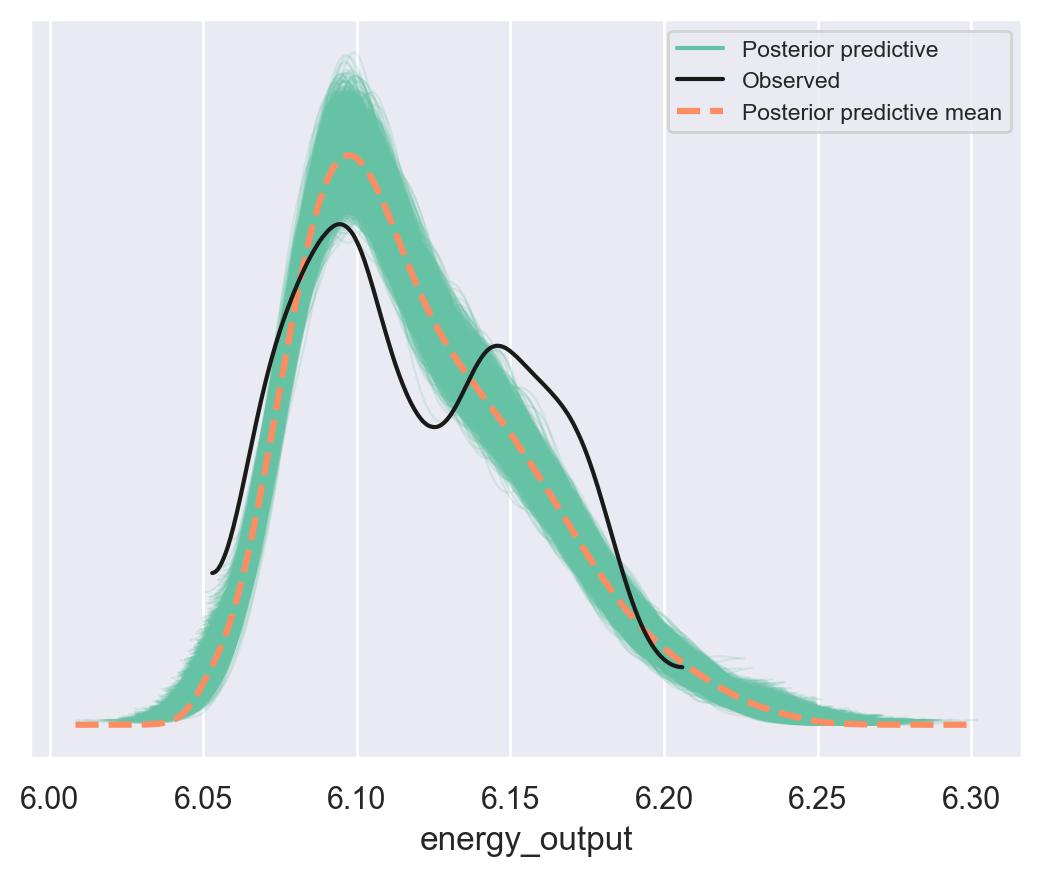

In [62]:
az.plot_ppc(output_model1_ppc,var_names=['energy_output'],observed=True)

#### Updating Model

##### Model 2 - Adding More Features

In [64]:
with pm.Model() as output_model2 : 
    # prior 
    a = pm.Normal('a',0,1)
    b1 = pm.Normal('b_temp',5,2)
    b2 = pm.Normal('b_exhaust',5,2)
    sigma = pm.Exponential('sigma',5)
    
    # likelihood
    
    linear_model = pm.Deterministic('mu', a + b1 * data['log_temp'].values \
                                   + b2 * data['log_exhaust'].values  )
    output = pm.Normal('energy_output',mu=linear_model,sigma=sigma,observed=data['output'].values)

with output_model2 :
      output_model2_prior = pm.sample_prior_predictive(draws=100,random_seed=72)


Sampling: [a, b_exhaust, b_temp, energy_output, sigma]


In [65]:
shape_prior_samples = output_model2_prior.prior['a'].values.flatten().shape[0]
n_data = data.shape[0] 
pred_output = np.zeros(( n_data , shape_prior_samples ))


# predicting priors using intercept + coefficient obtained from prior sampling
# sort values based on 
for idx in range(data.shape[0]) :
    pred_output[idx] = output_model2_prior.prior["a"] + output_model2_prior.prior["b_temp"]  * data['temp'].values[idx] \
                    +  output_model2_prior.prior["b_exhaust"]  * data['exhaust'].values[idx] 


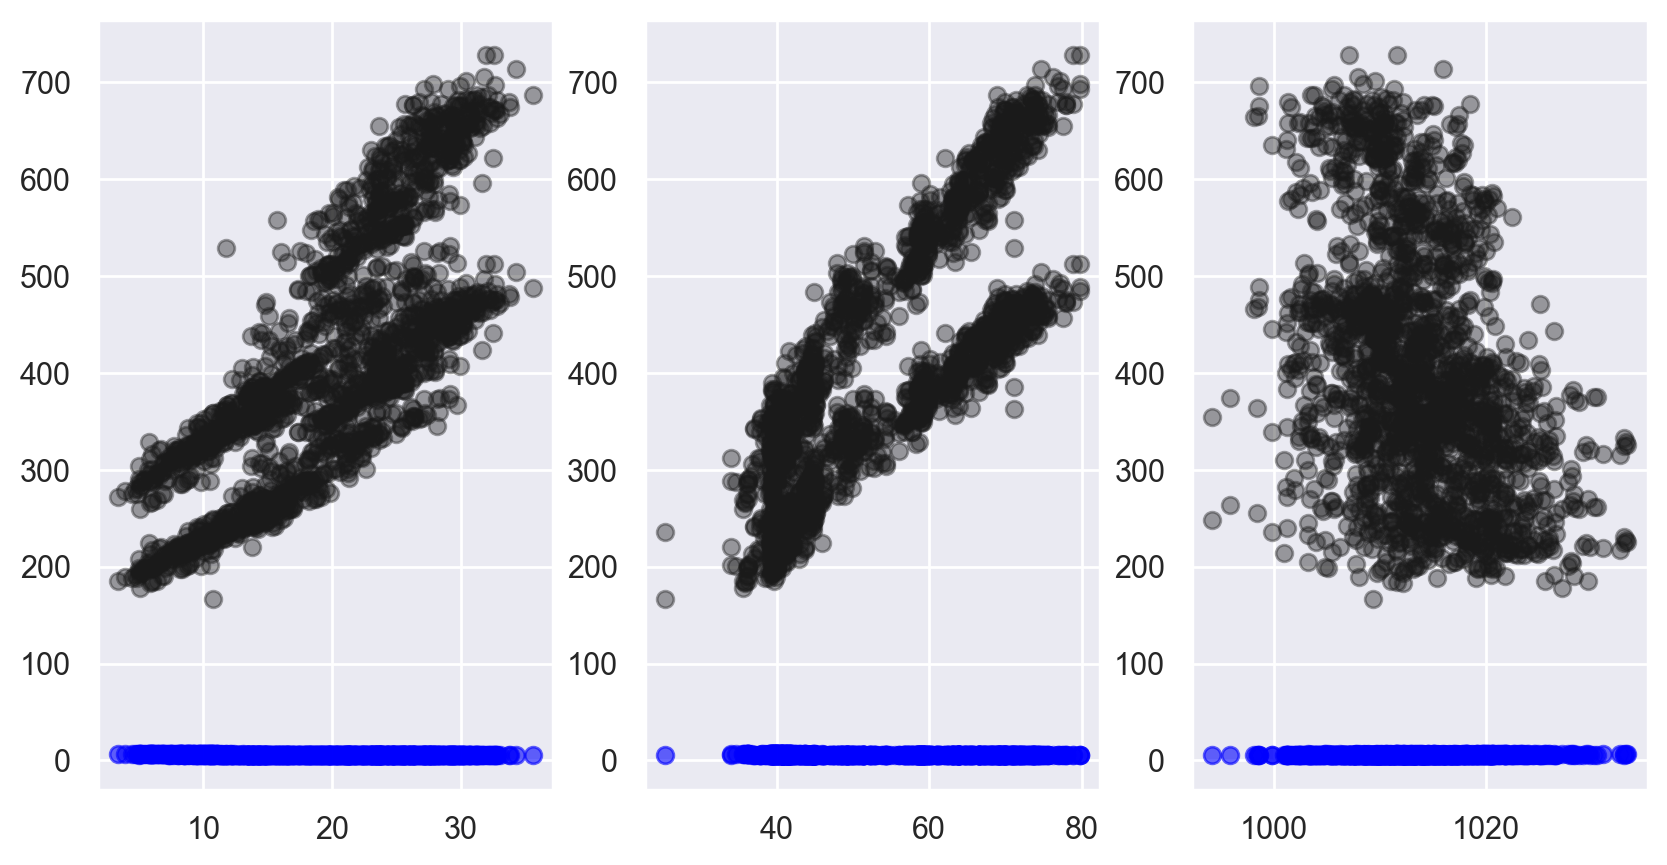

In [66]:
index_ = data['temp'].values.argsort()
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,5))

# 
for idx in range(2) : 
    ax[0].scatter(data['temp'].values[index_],pred_output[index_,idx], c="k", alpha=0.4)
    
ax[0].scatter(data['temp'].values[index_],data['log_output'].values[index_], c="blue", alpha=0.6)




index_exh = data['exhaust'].values.argsort()

# 
for idx in range(2) : 
    ax[1].scatter(data['exhaust'].values[index_exh],pred_output[index_exh,idx], c="k", alpha=0.4)
    
ax[1].scatter(data['exhaust'].values[index_exh],data['log_output'].values[index_exh], c="blue", alpha=0.6)


index_pres = data['pressure'].values.argsort()

for idx in range(2) : 
    ax[2].scatter(data['pressure'].values[index_pres],pred_output[index_pres,idx], c="k", alpha=0.4)
    
ax[2].scatter(data['pressure'].values[index_pres],data['log_output'].values[index_pres], c="blue", alpha=0.6)


In [67]:
with output_model2 :
      output_model2_trace = pm.sample(2000,random_seed=72,target_accept=0.9)
    
az.summary(output_model2_trace,var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_temp, b_exhaust, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a           2.925  0.969   1.071    4.705      0.013    0.009    5520.0   
b_exhaust  11.818  0.237  11.381   12.265      0.004    0.003    3353.0   
b_temp    -10.503  0.622 -11.709   -9.381      0.011    0.008    3358.0   
sigma      86.953  1.550  84.007   89.795      0.020    0.014    6026.0   

           ess_tail  r_hat  
a            4857.0    1.0  
b_exhaust    4140.0    1.0  
b_temp       3753.0    1.0  
sigma        5061.0    1.0

In [68]:
with output_model2 :
    output_model2_ppc = pm.sample_posterior_predictive(output_model2_trace,var_names=['energy_output'],
                                                       random_seed=72)


Sampling: [energy_output]


Output()

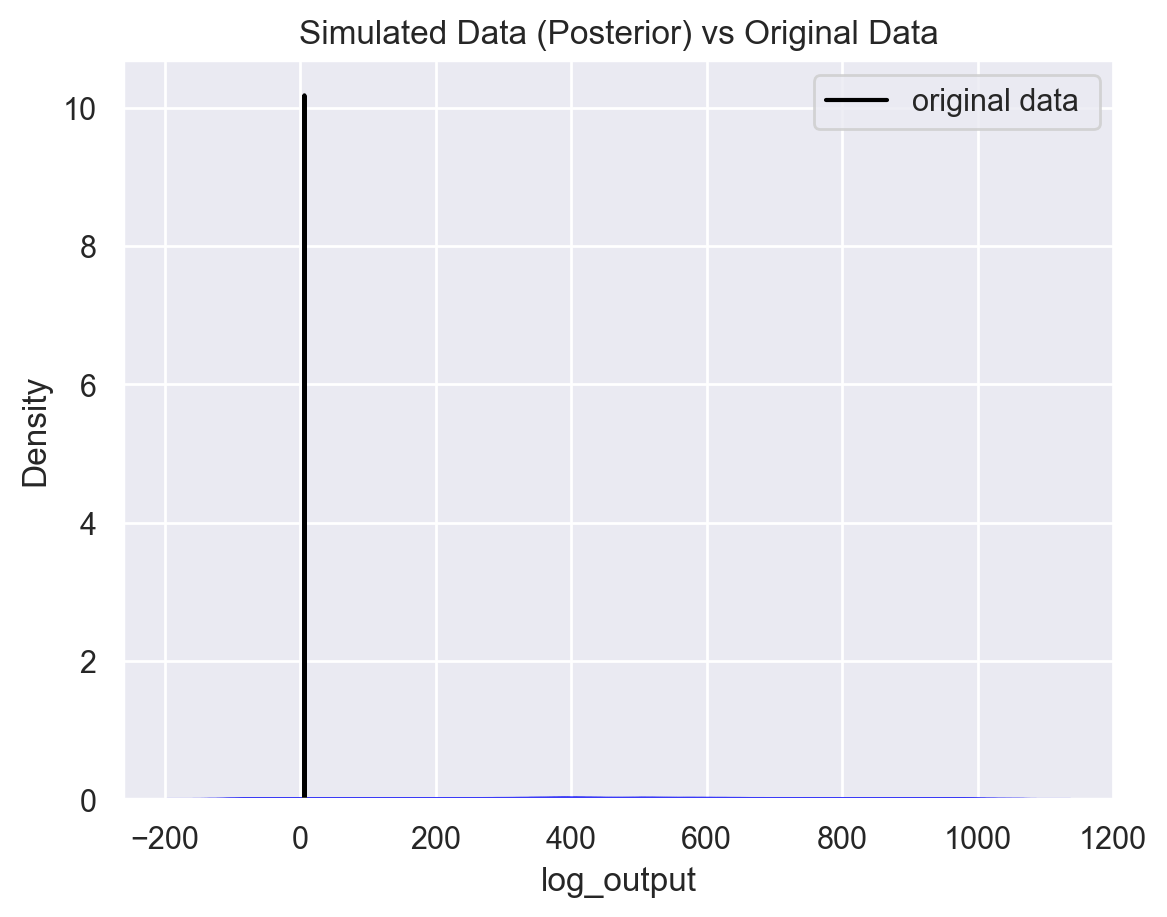

In [69]:
output_posterior = output_model2_ppc['posterior_predictive']['energy_output'].values
chain,draw,n_posterior_draw = output_posterior.shape
output_posterior = output_posterior.reshape(chain*draw,n_posterior_draw)

# plot the posterior 
fig,ax = plt.subplots()
for idx in range(output_posterior.shape[1]) : 
    sns.kdeplot(output_posterior[:,idx],alpha=0.1,color='blue')
sns.kdeplot(data['log_output'],label='original data ',color='black')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

<Axes: xlabel='energy_output'>

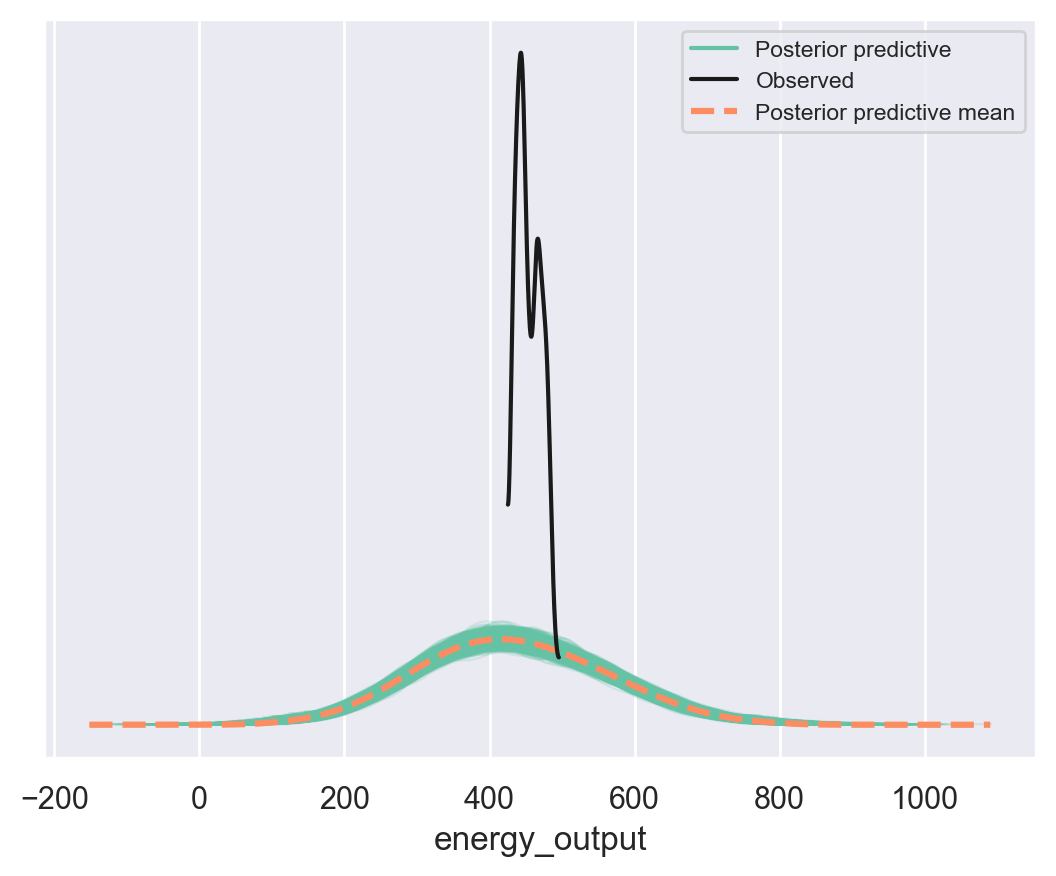

In [70]:
az.plot_ppc(output_model2_ppc,var_names=['energy_output'],observed=True)

##### Model 3 - Changing the Likelihood

In [71]:
with pm.Model() as output_model3 : 
    # prior 
    a = pm.Normal('a',0,1)
    b1 = pm.Normal('b_temp',2,1)
    b2 = pm.Normal('b_exhaust',2,1)
    sigma = pm.Exponential('sigma',1)
    nu = pm.Uniform('nu',1,3)
    
    # likelihood
    
    linear_model = pm.Deterministic('mu', a + b1 * data['log_temp'].values \
                                   + b2 * data['log_exhaust'].values  )

    # nu --> degree of freedom, nu=1 cauchy distribution 
    output = pm.StudentT('energy_output',nu=nu,mu=linear_model,sigma=sigma,observed=data['log_output'].values)

with output_model3 :
      output_model3_prior = pm.sample_prior_predictive(draws=100,random_seed=72)


Sampling: [a, b_exhaust, b_temp, energy_output, nu, sigma]


In [72]:
shape_prior_samples = output_model3_prior.prior['a'].values.flatten().shape[0]
n_data = data.shape[0] 
pred_output = np.zeros(( n_data , shape_prior_samples ))


# predicting priors using intercept + coefficient obtained from prior sampling
# sort values based on 
for idx in range(data.shape[0]) :
    pred_output[idx] = output_model3_prior.prior["a"] + output_model3_prior.prior["b_temp"]  * data['log_temp'].values[idx] \
                    +  output_model3_prior.prior["b_exhaust"]  * data['exhaust'].values[idx] 


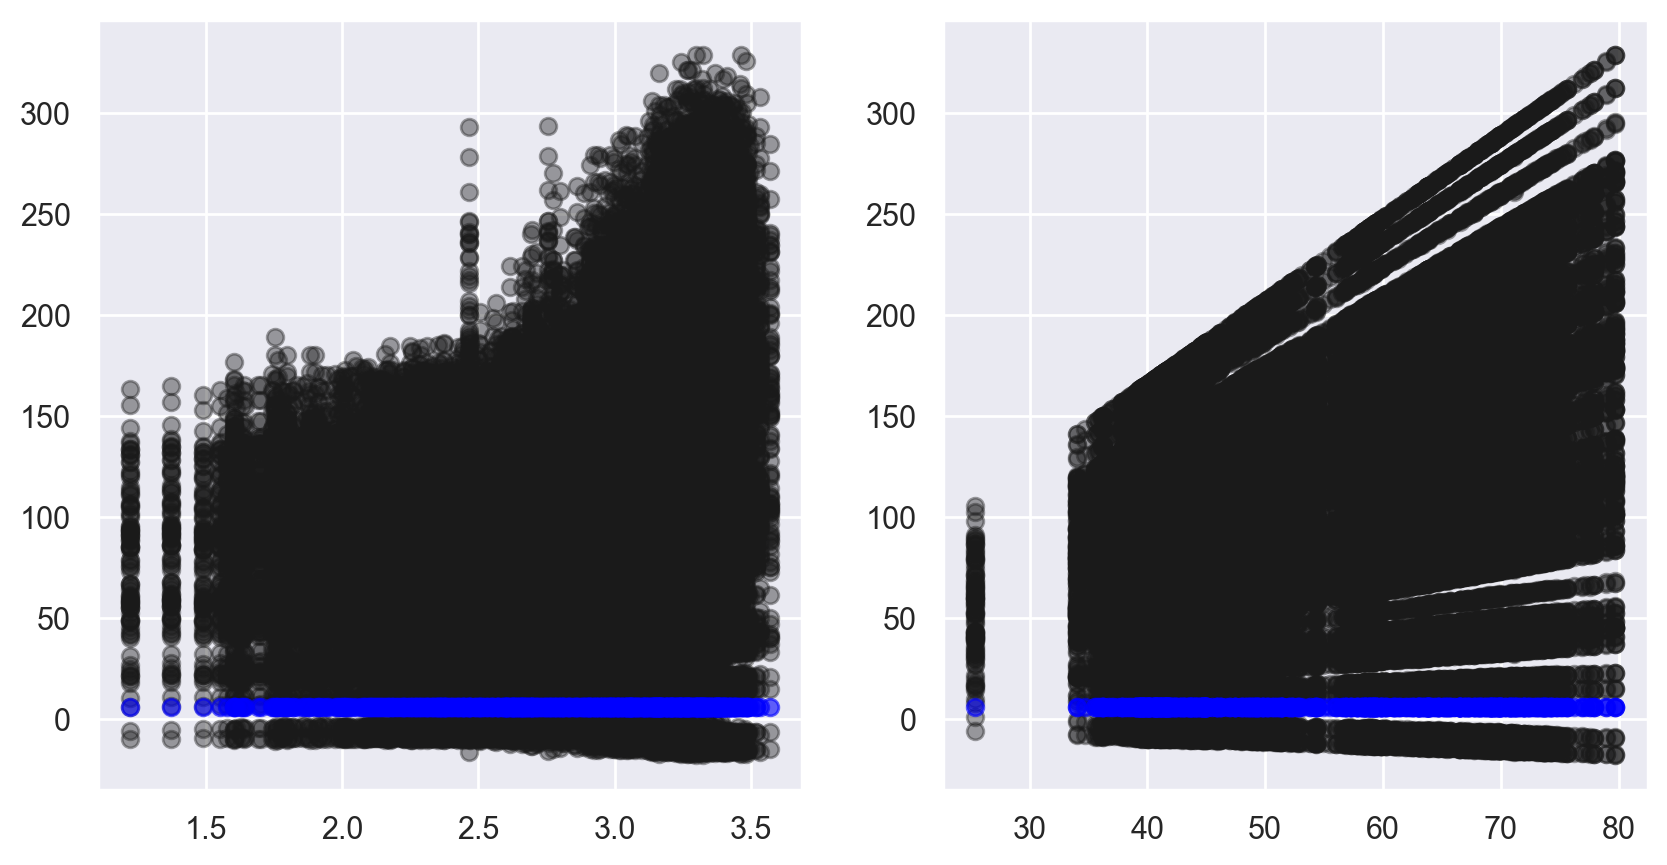

In [73]:
index_ = data['log_temp'].values.argsort()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

# 
for idx in range(100) : 
    ax[0].scatter(data['log_temp'].values[index_],pred_output[index_,idx], c="k", alpha=0.4)
    
ax[0].scatter(data['log_temp'].values[index_],data['log_output'].values[index_], c="blue", alpha=0.6)




index_hum = data['exhaust'].values.argsort()

# 
for idx in range(100) : 
    ax[1].scatter(data['exhaust'].values[index_hum],pred_output[index_hum,idx], c="k", alpha=0.4)
    
ax[1].scatter(data['exhaust'].values[index_hum],data['log_output'].values[index_hum], c="blue", alpha=0.6)




In [74]:
with output_model3 :
      output_model3_trace = pm.sample(2000,random_seed=72,target_accept=0.9)
    
az.summary(output_model3_trace,var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_temp, b_exhaust, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 78 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a          6.335  0.003   6.330    6.340      0.000      0.0    3812.0   
b_exhaust -0.001  0.000  -0.001   -0.001      0.000      0.0    3726.0   
b_temp    -0.055  0.001  -0.058   -0.053      0.000      0.0    3144.0   
nu         2.958  0.041   2.884    3.000      0.001      0.0    3905.0   
sigma      0.009  0.000   0.008    0.009      0.000      0.0    5217.0   

           ess_tail  r_hat  
a            4471.0    1.0  
b_exhaust    4266.0    1.0  
b_temp       3656.0    1.0  
nu           3007.0    1.0  
sigma        4657.0    1.0

Sampling: [energy_output]


Output()

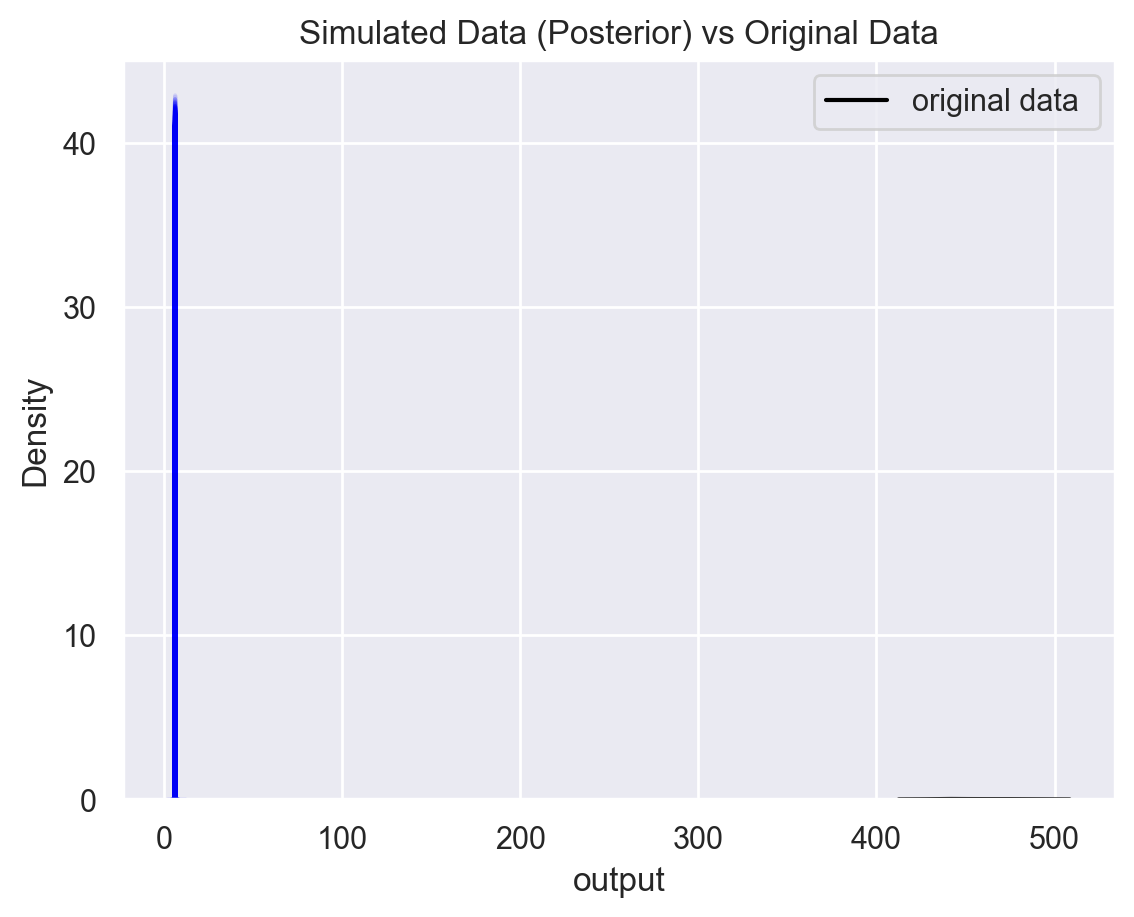

In [75]:
with output_model3 :
    output_model3_ppc = pm.sample_posterior_predictive(output_model3_trace,var_names=['energy_output'],
                                                       random_seed=72)


output_posterior = output_model3_ppc['posterior_predictive']['energy_output'].values
chain,draw,n_posterior_draw = output_posterior.shape
output_posterior = output_posterior.reshape(chain*draw,n_posterior_draw)

# plot the posterior 
fig,ax = plt.subplots()
for idx in range(output_posterior.shape[1]) : 
    sns.kdeplot(output_posterior[:,idx],alpha=0.1,color='blue')
sns.kdeplot(data['output'],label='original data ',color='black')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

<Axes: xlabel='energy_output'>

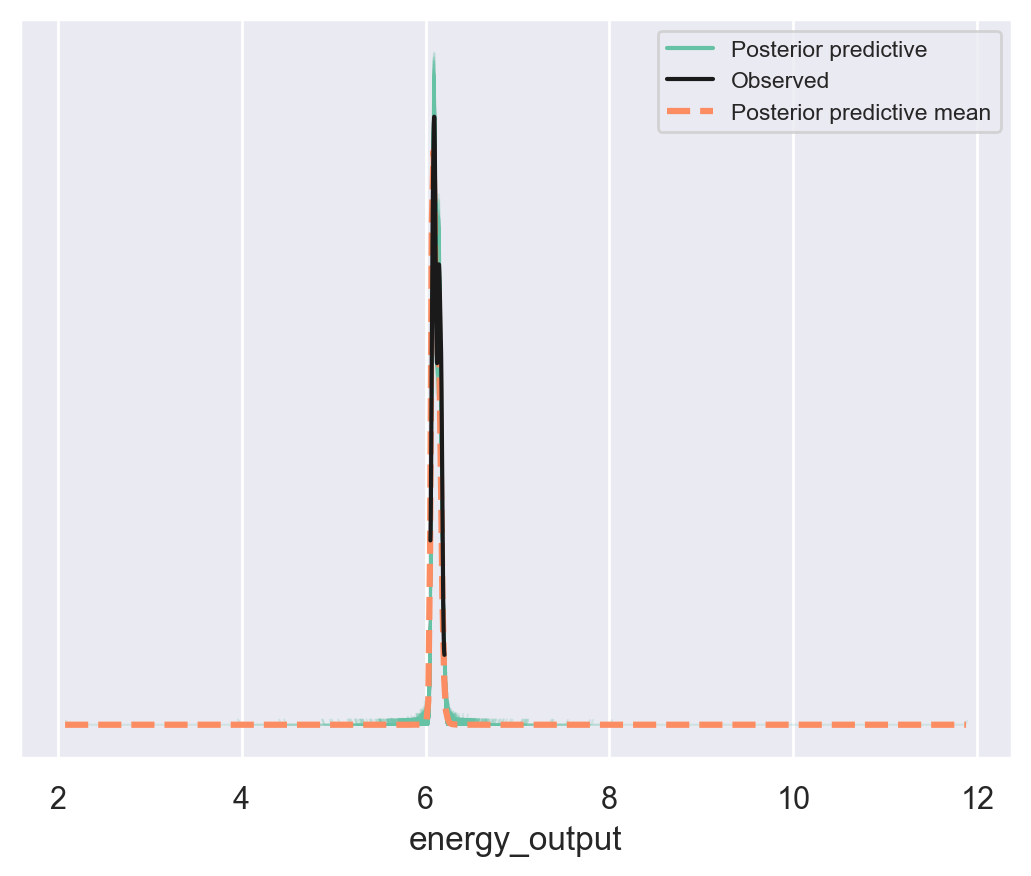

In [76]:
az.plot_ppc(output_model3_ppc,var_names=['energy_output'],observed=True)

##### Model 4 - Using all features with the updated likelihood

In [80]:
with pm.Model() as output_model4 : 
    # prior 
    a = pm.Normal('a',0,1)
    b1 = pm.Normal('b_temp',2,1)
    b2 = pm.Normal('b_exhaust',2,1)
    b3 = pm.Normal('b_pressure',2,1)
    b4 = pm.Normal('b_humid',2,1)
    sigma = pm.Exponential('sigma',1)
    nu = pm.Uniform('nu',1,3)
    
    # likelihood
    
    linear_model = pm.Deterministic('mu', a + b1 * data['log_temp'].values \
                                   + b2 * data['log_exhaust'].values \
                                      + b3 * data['log_pressure'].values \
                                          + b4 * data['log_humid'].values  )

    # nu --> degree of freedom, nu=1 cauchy distribution 
    output = pm.StudentT('energy_output',nu=nu,mu=linear_model,sigma=sigma,observed=data['log_output'].values)

with output_model4 :
      output_model4_prior = pm.sample_prior_predictive(draws=100,random_seed=72)


Sampling: [a, b_exhaust, b_humid, b_pressure, b_temp, energy_output, nu, sigma]


In [82]:
with output_model4 :
      output_model4_trace = pm.sample(2000,random_seed=72,target_accept=0.9)
    
az.summary(output_model4_trace,var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_temp, b_exhaust, b_pressure, b_humid, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1038 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a           2.473  0.408   1.684    3.214      0.026    0.018     244.0   
b_exhaust  -0.052  0.003  -0.057   -0.046      0.000    0.000     248.0   
b_humid    -0.008  0.002  -0.012   -0.005      0.000    0.000     341.0   
b_pressure  0.585  0.058   0.476    0.696      0.004    0.003     245.0   
b_temp     -0.056  0.002  -0.058   -0.052      0.000    0.000     216.0   
nu          2.959  0.039   2.891    3.000      0.002    0.001     435.0   
sigma       0.008  0.000   0.008    0.009      0.000    0.000     414.0   

            ess_tail  r_hat  
a              467.0   1.00  
b_exhaust      486.0   1.02  
b_humid        747.0   1.02  
b_pressure     469.0   1.00  
b_temp         569.0   1.02  
nu             702.0   1.01  
sigma          872.0   1.01

Sampling: [energy_output]


Output()

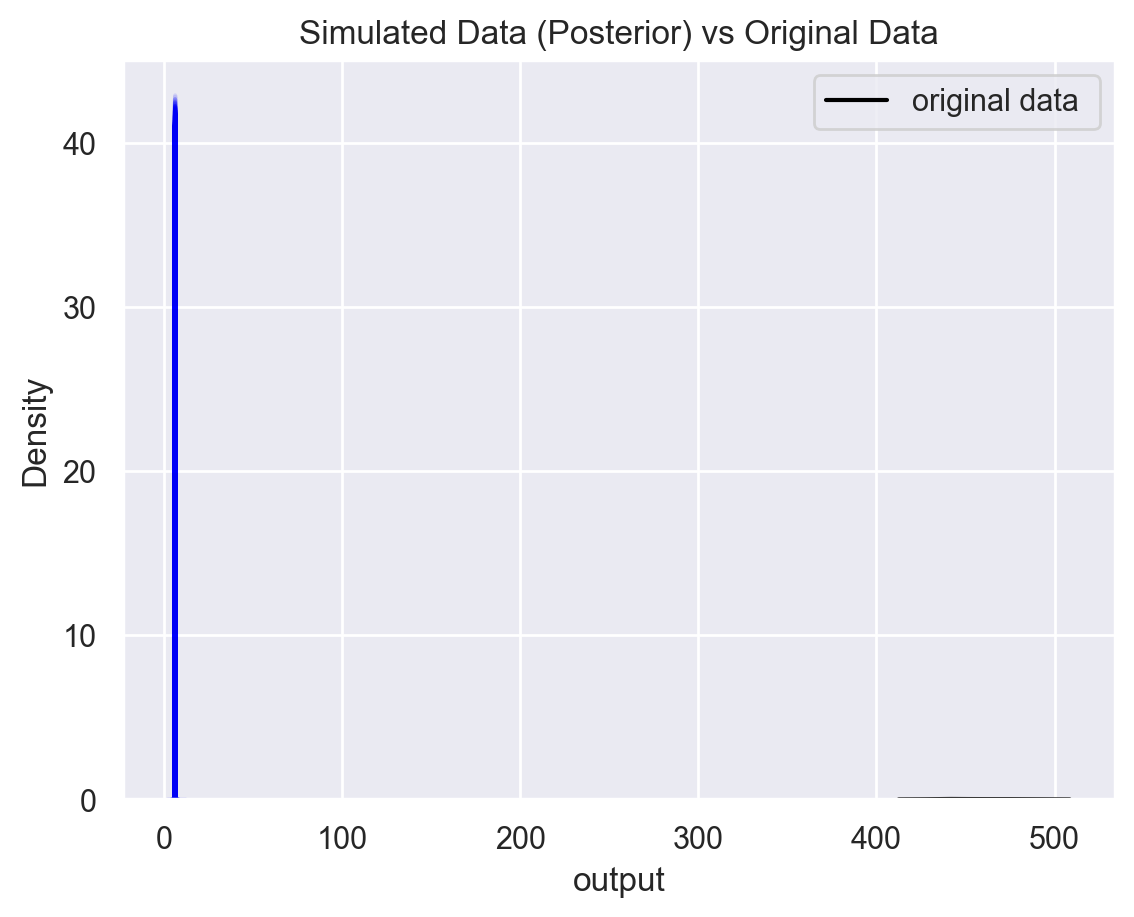

In [90]:
with output_model4 :
    output_model4_ppc = pm.sample_posterior_predictive(output_model4_trace,var_names=['energy_output'],
                                                       random_seed=72)


output_posterior = output_model3_ppc['posterior_predictive']['energy_output'].values
chain,draw,n_posterior_draw = output_posterior.shape
output_posterior = output_posterior.reshape(chain*draw,n_posterior_draw)

# plot the posterior 
fig,ax = plt.subplots()
for idx in range(output_posterior.shape[1]) : 
    sns.kdeplot(output_posterior[:,idx],alpha=0.1,color='blue')
sns.kdeplot(data['output'],label='original data ',color='black')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

<Axes: xlabel='energy_output'>

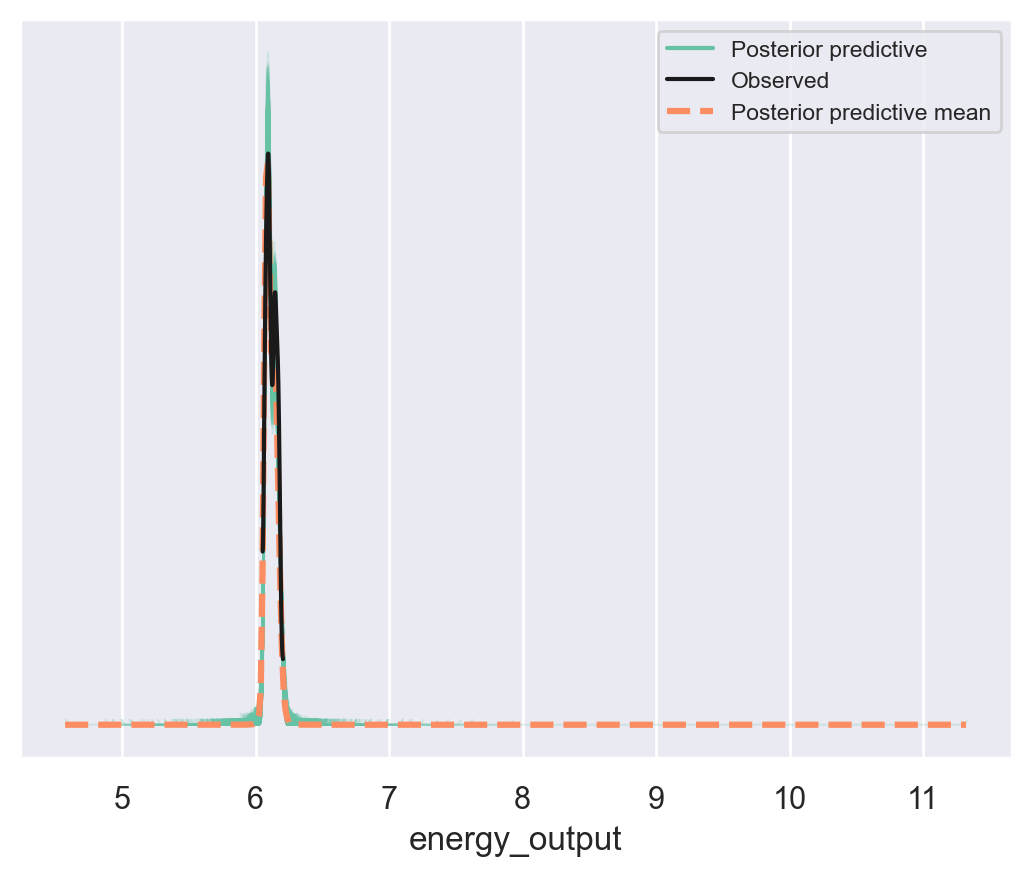

In [91]:
az.plot_ppc(output_model4_ppc,var_names=['energy_output'],observed=True)

#### Comparing Model

In [84]:
with output_model1 : 
    loglike_model1 = pm.compute_log_likelihood(output_model1_trace)
with output_model2 : 
    loglike_model2 = pm.compute_log_likelihood(output_model2_trace)
with output_model3 : 
    loglike_model3 = pm.compute_log_likelihood(output_model3_trace)

with output_model4 : 
    loglike_model4 = pm.compute_log_likelihood(output_model4_trace)

Output()

Output()

Output()

Output()

In [88]:
df_comp_waic = az.compare({"model1": loglike_model1, "model2": loglike_model2, "model3": loglike_model3, "model4": loglike_model4},ic='waic',scale='deviance')
df_comp_waic

rank     elpd_waic    p_waic     elpd_diff        weight         se  \
model4     0  -6245.133802  7.630358      0.000000  8.067233e-01  44.236646   
model3     1  -6160.136461  5.038785     84.997341  1.932767e-01  44.548057   
model1     2  -5794.786016  3.915937    450.347786  3.174972e-11  50.488264   
model2     3  12204.518848  3.351817  18449.652650  0.000000e+00  41.004710   

              dse  warning     scale  
model4   0.000000    False  deviance  
model3  23.929885    False  deviance  
model1  40.727295    False  deviance  
model2  59.430689    False  deviance

Model 4 has the least likelihood